In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import japanize_matplotlib
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F

In [2]:
transform = transforms.Compose([
    transforms.Resize((5, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = datasets.MNIST(root="../../data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../../data", train=False, download=True, transform=transform)

In [4]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([1, 5, 5]) 5
tensor([[[-0.4242, -0.3224, -0.0806, -0.0042, -0.2842],
         [-0.4242,  0.4668,  1.3577,  0.4286, -0.2460],
         [-0.4242, -0.2842,  0.6450,  0.1740, -0.4242],
         [-0.3606,  0.1231,  1.0523,  0.5813, -0.4242],
         [-0.1569,  0.6450,  0.1740, -0.3733, -0.4242]]])


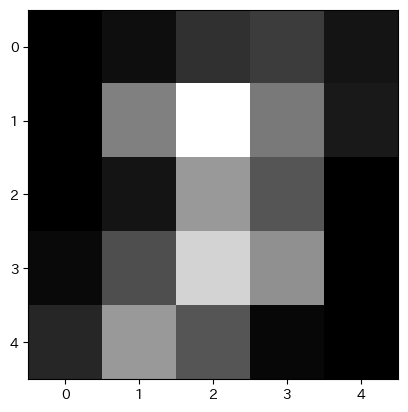

In [9]:
x_sample, y_sample = train_dataset[0]
print(x_sample.shape, y_sample)
print(x_sample)

# img = x_sample[0]
img = x_sample.permute(1, 2, 0) # imshowで画像を表示する際は、高さ、幅、チャンネル
plt.imshow(img, cmap="gray")
plt.show()

## 二次元データの畳込み

In [6]:
# フィルターの定義
H = torch.tensor([
    [2, 0, -2],
    [0, 2, 0],
    [-2, 0, 2],
], dtype=torch.float)

In [ ]:
def convolutionDim2(x, H, S=1, P=0):

    try:
        w = x.shape[1] # 特徴マップの高さ
        h = H.shape[0] # フィルタの高さ
        output_size = ((w + 2*P - h) / S) + 1
        
        # print(f"畳み込み後のサイズ：{output_size} {type(output_size)}")
        if not output_size.is_integer() or  output_size <= 0: # 少数が整数になりえない、またはサイズが0以下のとき、畳み込み不可
            raise ValueError("畳み込み出来ません")

    except ValueError as e:
        print(e)
    else:
        output_size = int(output_size)
        u = torch.zeros(output_size, output_size)

        for i in range(output_size):
            for j in range(output_size):
                cell = 0
                for p in range(h):
                    for q in range(h):
                        cell += x[0, i + p, j + q] * H[p, q]
                
                u[i, j] = cell
        
    return u

In [17]:
u = convolutionDim2(x_sample, H, S=1)
print(u)
print(torch.sum(x_sample[0, :3, :3]  * H))
print(torch.sum(x_sample[0, 1:4, :3]  * H))

3
tensor([[ 2.3845,  2.9955, -0.8739],
        [-1.3066,  2.2827,  0.6026],
        [-1.2303, -0.8484,  2.1045]])
tensor(2.3845)
tensor(-1.3066)


バイアスの追加

In [18]:
b = 3
u = u + b
print(u)

tensor([[5.3845, 5.9955, 2.1261],
        [1.6934, 5.2827, 3.6026],
        [1.7697, 2.1516, 5.1045]])


## 三次元データの畳込み

In [19]:
train_dataset = datasets.CIFAR10(root="../../data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="../../data", train=False, transform=transform, download=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008547009..2.121434].


torch.Size([3, 5, 5]) 6


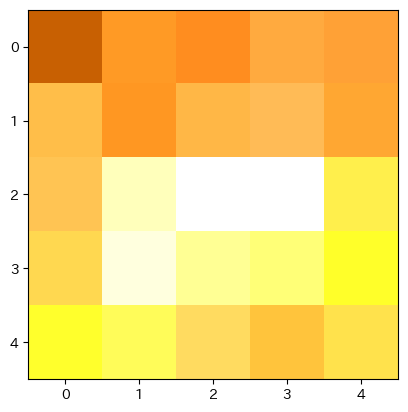

In [20]:
x_sample, y_sample = train_dataset[0]
print(x_sample.shape, y_sample)

img = x_sample.permute(1, 2, 0)
plt.imshow(img)
plt.show()

In [22]:
def convolutionDim3(x, H, S=1, P=0):
    """3次元の一枚の画像データを畳み込む
    フィルタも3次元
    """
    try:
        channel = x.shape[0] # チャンネル数を取得
        w = x.shape[1] # 特徴マップの高さ
        h = H.shape[0] # フィルタの高さ
        output_size = ((w + 2*P - h) / S) + 1
        
        # print(f"畳み込み後のサイズ：{output_size} {type(output_size)}")
        if not output_size.is_integer() or  output_size <= 0: # 少数が整数になりえない、またはサイズが0以下のとき、畳み込み不可
            raise ValueError("畳み込み出来ません")

    except ValueError as e:
        print(e)
    else:
        output_size = int(output_size)
        u = torch.zeros(channel, output_size, output_size)

        for c in range(channel): # チャンネル
            for i in range(output_size):
                for j in range(output_size):
                    cell = 0
                    for p in range(h):
                        for q in range(h):
                            cell += x[c, i + p, j + q] * H[c, p, q] # チャンネルを考慮
                    
                    u[c, i, j] = cell
        
        u = torch.sum(u, dim=0) # チャンネル方向に足し合わせる
        
    return u

In [23]:
H = torch.randn((3, 3, 3))
print(H)

tensor([[[-0.4910, -0.9026,  1.0883],
         [ 0.2552, -0.1153, -0.3729],
         [ 0.1589, -0.8793, -0.6969]],

        [[-1.9965, -0.3788,  0.2069],
         [-1.5207,  0.1279, -0.3638],
         [-0.4714,  1.1833,  0.2958]],

        [[-0.4684, -0.3095,  0.0670],
         [-0.1556,  0.6361, -0.2556],
         [ 0.8101,  1.4726,  1.0646]]])


In [24]:
u = convolutionDim3(x_sample, H)
print(u)

print(torch.sum(x_sample[:, :3, :3] * H))
print(torch.sum(x_sample[:, 1:4, :3] * H))

tensor([[-1.2872, -0.2528, -0.9736],
        [-2.9309, -3.1860, -4.3785],
        [-3.4367, -6.2687, -8.2695]])
tensor(-1.2872)
tensor(-2.9309)


## 出力が他チャンネルになる3次元畳み込み

In [ ]:
H = torch.randn(5, 3, 3, 3) # 特徴マップとチャンネル数を合わせる
print(H.shape)

torch.Size([5, 3, 3, 3])


In [48]:
def convolutionBlock(x, H, S=1, P=0):
    w = x.shape[1]
    h = H.shape[2]
    channel = x.shape[0]
    fn = H.shape[0] # アウトプットのチャンネル数

    try:
        output_size = ((w + 2*P - h) / S) + 1

        if not output_size.is_integer() or output_size <= 0:
            raise ValueError("畳み込み出来ません")
    except ValueError as e:
        print(e)
    else:
        output_size = int(output_size)
        u = torch.zeros(fn, channel, output_size, output_size)

        for f in range(fn): # 5
            for c in range(channel): # 
                for i in range(output_size): # 3
                    for j in range(output_size): # 3
                        cell = 0
                        for p in range(h): # 3
                            for q in range(h): # 3
                                cell += x[c, i + p, j + q] * H[f, c, p, q] 
                        
                        u[f, c, i, j] = cell
        
        u = torch.sum(u, dim=1) # チャンネル方向に足し合わせる
    return u


In [49]:
u = convolutionBlock(x_sample, H)
print(u.shape)

torch.Size([5, 3, 3])
